### Activity 7.01 : Building DCGAN for MNIST FASHION

In [1]:
# Import the required library functions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU,BatchNormalization
from tensorflow.keras.layers import Conv2D, UpSampling2D,Conv2DTranspose
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam

In [2]:
# Function to generate real data samples
def realData(batch):
    # Get the MNIST data 
    (X_train, _), (_, _) = fashion_mnist.load_data()
    # Reshaping the input data to include channel
    X = X_train[:,:,:,np.newaxis]
    # normalising the data to be between 0 and 1
    X = X.astype('float32')/255.0
    # Generating a batch of data
    imageBatch = X[np.random.randint(0, X.shape[0], size=batch)]
    return imageBatch
    

In [4]:
# Generating one sample of the data
fashionData = realData(2)

4423680/4422102 [==============================] - 8s 2us/step


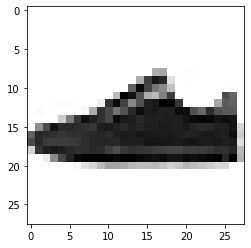

In [6]:
# Plot the image
plt.imshow(fashionData[1, :, :, 0], cmap='gray_r')

In [7]:
# Function to generate inputs for generator function
def fakeInputs(batch,infeats):
    # Generate random noise data with shape (batch,input features)
    x_fake = np.random.normal(0,1,size=[batch,infeats])
    return x_fake

In [8]:
# Function for the generator model
def genModel(infeats):
    # Defining the Generator model
    Genmodel = Sequential()
    Genmodel.add(Dense(128*7*7,input_dim=infeats))
    Genmodel.add(LeakyReLU(0.2))
    Genmodel.add(Reshape((7, 7, 128)))
    # Upsample to 14 x 14
    Genmodel.add(Conv2DTranspose(128,kernel_size=(4,4),strides=(2,2),padding='same'))    
    Genmodel.add(LeakyReLU(0.2))
    # Updample to 28 x 28
    Genmodel.add(Conv2DTranspose(128,kernel_size=(4,4),strides=(2,2),padding='same'))    
    Genmodel.add(LeakyReLU(0.2))
    Genmodel.add(Conv2D(1, kernel_size=(7, 7), padding='same', activation='sigmoid'))
    return Genmodel



In [9]:
# Function to create fake samples using the generator model
def fakedataGenerator(Genmodel,batch,infeats):
    # first generate the inputs to the model
    genInputs = fakeInputs(batch,infeats)
    # use these inputs inside the generator model to generate fake distribution
    X_fake = Genmodel.predict(genInputs)   
    
    return X_fake

In [10]:
# Define the arguments like batch size and input feature
batch = 128
infeats = 100
Genmodel = genModel(infeats)
Genmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 128)       0

In [11]:
# Generating a fake sample and printing the shape
fake = fakedataGenerator(Genmodel,batch,infeats)
fake.shape

(128, 28, 28, 1)

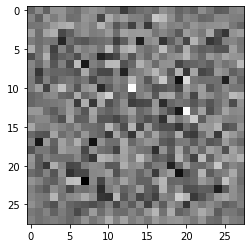

In [12]:
# Plotting the fake sample

plt.imshow(fake[1, :, :, 0], cmap='gray_r')

In [13]:
# Descriminator model as a function
def discModel():
    Discmodel = Sequential()
    Discmodel.add(Conv2D(64,kernel_size=(3,3),strides=(2,2),padding='same',input_shape=(28,28,1)))    
    Discmodel.add(LeakyReLU(0.2))
    Discmodel.add(Dropout(0.4))
    Discmodel.add(Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding='same'))   
    Discmodel.add(LeakyReLU(0.2))
    Discmodel.add(Dropout(0.4))
    Discmodel.add(Flatten())
    Discmodel.add(Dense(1, activation='sigmoid'))
    Discmodel.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5),metrics=['accuracy'])   
    return Discmodel 

In [14]:
# Print the summary of the discriminator model
Discmodel = discModel()
Discmodel.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)             

Next we develop the GAN model 

In [15]:
# Define the combined generator and discriminator model, for updating the generator
def ganModel(Genmodel,Discmodel):
    # First define that discriminator model cannot be trained
    Discmodel.trainable = False
    Ganmodel = Sequential()
    # First adding the generator model
    Ganmodel.add(Genmodel)
    # Next adding the discriminator model without training the parameters
    Ganmodel.add(Discmodel)
    # Compile the model for loss to optimise the Generator model
    Ganmodel.compile(loss='binary_crossentropy',optimizer = Adam(lr=0.0002, beta_1=0.5))    
    return Ganmodel

In [16]:
# Initialise the gan model
gan_model = ganModel(Genmodel,Discmodel)
# Print summary of the GAN model
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


In [17]:
# Defining the number of epochs
nEpochs = 100

In [22]:
# Train the GAN network
for i in range(nEpochs):
    # Generate samples equal to the bath size from the real distribution
    x_real = realData(batch)
    # Generate fake samples using the fake data generator function
    x_fake = fakedataGenerator(Genmodel,batch,infeats)
    # Concatenating the real and fake data 
    X = np.concatenate([x_real,x_fake])
    # Creating the dependent variable and initializing them as '0'
    Y = np.zeros(batch * 2)
    # making the first set equivalent to batch with labels 1
    Y[:batch] = 1
    # train the  discriminator on the real samples
    discLoss = Discmodel.train_on_batch(X, Y)
    # Generate new fake inputs for training the GAN network
    x_gan = fakeInputs(batch*2,infeats)
    # Create labels of the fake examples as 1 to fool the discriminator
    y_gan = np.ones((batch*2, 1))
    # Update the generator model through the discriminator model
    gan_model.train_on_batch(x_gan, y_gan)
    # Print the accuracy measures on the real and fake data for every 10 epochs
    if (i) % 10 == 0:
        # Printing the descriminator loss and accuracy
        x_real_test = realData(10)
        x_fake_test = fakedataGenerator(Genmodel,10,infeats)
        # Concatenating the real and fake data 
        X_test = np.concatenate([x_real_test,x_fake_test])
        # Creating the dependent variable and initializing them as '0'
        Y = np.zeros(20 * 2)
        Y[:10] = 1
        # Predicting probabilities
        preds = Discmodel.predict_proba(X_test)
        print('Discriminator probability:{D}'.format(D=np.mean(preds)))
        # Generate fake samples using the fake data generator function
        x_fake = fakedataGenerator(Genmodel,batch,infeats)
        # Saving the plots
        for j in range(5*5):
            pyplot.subplot(5,5,j+1)
            pyplot.imshow(x_fake[j,:,:,0],cmap='gray_r')             
        filename = 'GAN_MNIST_Fashion_Training_Plot%03d.png' % (i+200)
        pyplot.savefig(filename)
        pyplot.close()
            
        


Discriminator probability:0.5570241808891296
Discriminator probability:0.49632468819618225
Discriminator probability:0.46051836013793945
Discriminator probability:0.53398597240448
Discriminator probability:0.5486909747123718
Discriminator probability:0.3977210223674774
Discriminator probability:0.5163196325302124
Discriminator probability:0.5506702065467834
Discriminator probability:0.43232065439224243
Discriminator probability:0.44940024614334106
